In [1]:
from nn_mri import ImageFitting_set, SineLayer, get_mgrid
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from skimage.color import rgb2gray, gray2rgb
from torch import nn
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.cluster import AgglomerativeClustering
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.io as sio
import os
import argparse
from csv import writer

In [7]:
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, 
                 hidden_layers, out_features, 
                 first_omega_0=30., 
                 hidden_omega_0=30.,
                 perturb=False):
        super().__init__()
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))
        self.relu = nn.ReLU()
        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))
        self.net.append(nn.Linear(hidden_features, hidden_features))
        self.net.append(nn.ReLU())
        self.final_linear = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        #self.net.append(final_linear)
        self.net = nn.Sequential(*self.net)
        self.perturb_linear = nn.Linear(3, hidden_features)
        self.perturb_linear2 = nn.Linear(hidden_features, out_features)
        with torch.no_grad():
            self.perturb_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
            self.perturb_linear2.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, np.sqrt(6 / hidden_features) / hidden_omega_0)
        self.tanh = nn.Tanh()  
        self.perturb = perturb
    def forward(self, coords, sample=0,eps=0):
        coords = coords.clone().detach().requires_grad_(False) # allows to take derivative w.r.t. input
        if self.perturb:
            acq = torch.tensor([sample], dtype=torch.float).cuda()
            acq = acq.repeat(coords.size(0),1)
            perturbation = self.perturb_linear(torch.cat((model_input, acq),-1))
            perturbation = self.tanh(perturbation)
            perturbation = self.perturb_linear2(perturbation)
            pertubation = eps*self.tanh(perturbation)
            coords = coords + pertubation
        output = self.net(coords)
        output = self.final_linear(output)
        output = self.relu(output)
        return output

In [2]:
class kiwi:
    def __init__(self, img_id):

        self.img_id = img_id
        file_address = '/scratch/midway3/gundogdu/matfiles'
        filename = os.path.join(file_address, img_id)
        self.dwi = sio.loadmat(filename)['img']

In [3]:
file_address = '/scratch/midway3/gundogdu/matfiles'
kiwi_scans = []
for f in os.listdir(file_address):
    kiwi_scans.append(kiwi(f))

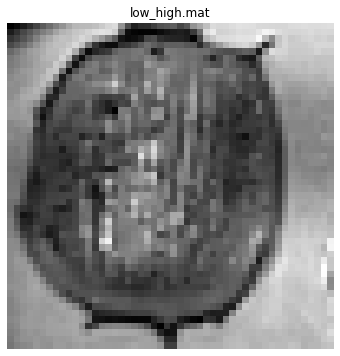

In [4]:
_kiwi = kiwi_scans[7]
dwi = _kiwi.dwi[40:90,20:70]
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(dwi, cmap='gray')
ax.set_title(_kiwi.img_id)
ax.axis('off')
plt.show()

In [8]:
img_dataset = []
mean_img = np.zeros(_kiwi.dwi[40:90,20:70].shape)
ctr = 0
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if not 'high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]
        mean_img += _kiwi.dwi[40:90,20:70]
        ctr +=1
        img_dataset.append(Image.fromarray(img))
mean_img /= ctr
dataset = ImageFitting_set(img_dataset)

/scratch/midway3/gundogdu/MRI-super-resolution/implicit-neural-representations/nn_mri.py:168: RuntimeWarning: invalid value encountered in add
  self.mean = sum(self.orig)/len(self.orig)


In [15]:
dataloader = DataLoader(dataset, batch_size=1, pin_memory=True, num_workers=0)
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=False)
img_siren.cuda()
torch.cuda.empty_cache()
optim = torch.optim.Adam(lr=3e-4, params=img_siren.parameters())

In [16]:
#params1 = list(img_siren.perturb_linear.parameters()) + list(img_siren.perturb_linear2.parameters())
#optim1 = torch.optim.Adam(lr=3e-4, params=params1)
#params2 = list(img_siren.net.parameters()) + list(img_siren.final_linear.parameters())
#optim2 = torch.optim.Adam(lr=0.000001, params=params2)
ctr = 0
new_loss = 1000


while True:
    for sample in range(9):
        ground_truth, model_input  = dataset.pixels[sample], dataset.coords[sample]
        ground_truth, model_input = ground_truth.cuda(), model_input.cuda()
        ground_truth /= ground_truth.max()
        model_output = img_siren(model_input)
        if not sample:
            loss = ((model_output - ground_truth)**2).mean()
        else:
            loss += ((model_output - ground_truth)**2).mean()
    optim.zero_grad()
    #optim2.zero_grad()
    loss.backward()
    optim.step()
    #optim2.step()
    if loss.item() > new_loss and ctr>100:
        break      
    else:
        new_loss = loss.item()
    if not ctr%500:
        print(new_loss)

    ctr +=1

2.24143385887146


Text(0.5, 1.0, 'super')

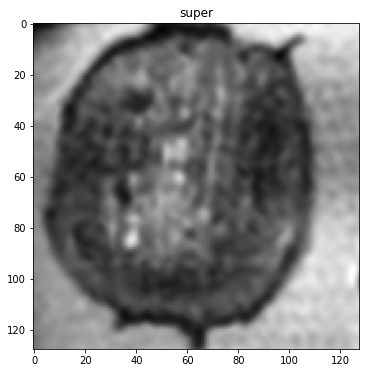

In [17]:
model_input  = get_mgrid(128, 2).cuda()
recon = img_siren(model_input).cpu().view(128,128).detach().numpy()


fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.imshow(recon, cmap='gray')
ax.set_title('super')


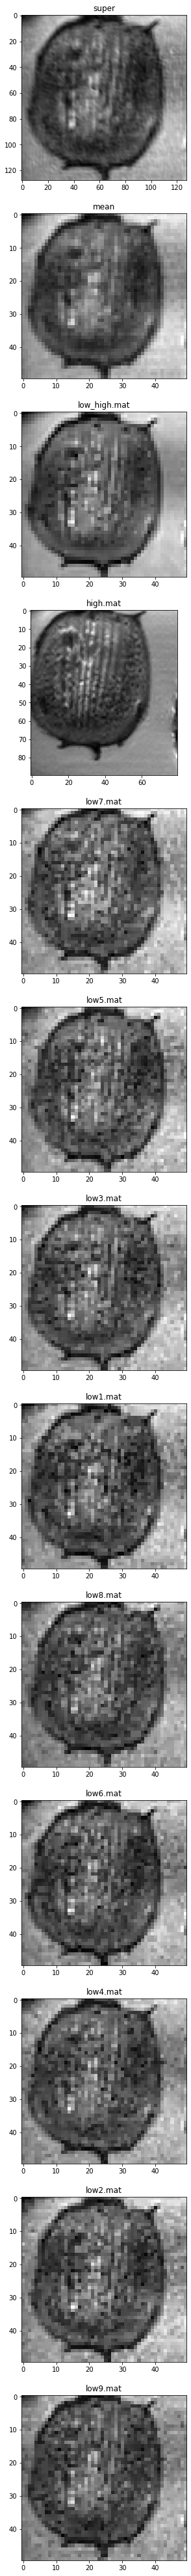

In [10]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/64.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(13,1,figsize=(6,72))
ax[0].imshow(mean_recon, cmap='gray')
ax[0].set_title('super')
ax[1].imshow(mean_img,cmap='gray')
ax[1].set_title('mean')
i=4
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(img,cmap='gray')
        ax[2].set_title(_kiwi.img_id)
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:160,40:120]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title(_kiwi.img_id)
    else:
        img = _kiwi.dwi[40:90,20:70]   
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(_kiwi.img_id)
        i+=1


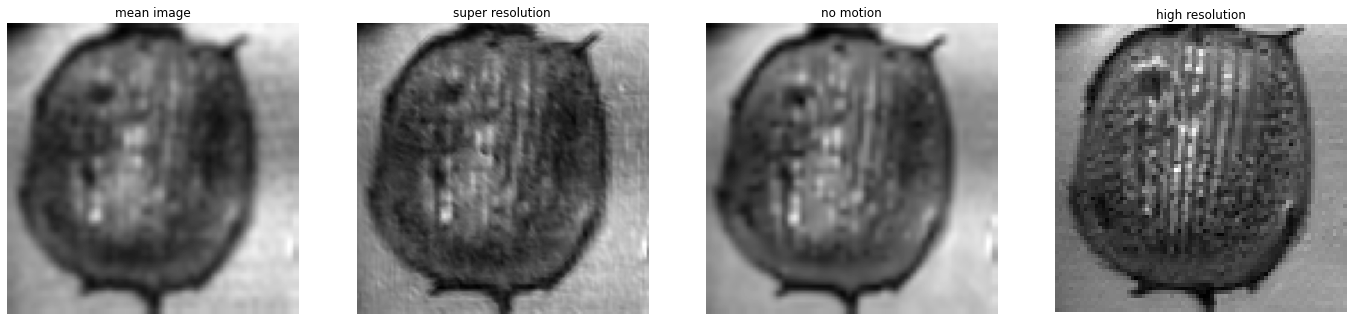

In [29]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/60.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(1,4, figsize=(24,6))
ax[1].imshow(mean_recon, cmap='gray')
ax[1].set_title('super resolution')
ax[0].imshow(rescale(mean_img,2),cmap='gray')
ax[0].set_title('mean image')

for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(rescale(img,2),cmap='gray')
        ax[2].set_title('no motion')
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:150,34:115]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title('high resolution')
for i in range(4):
    ax[i].axis('off')

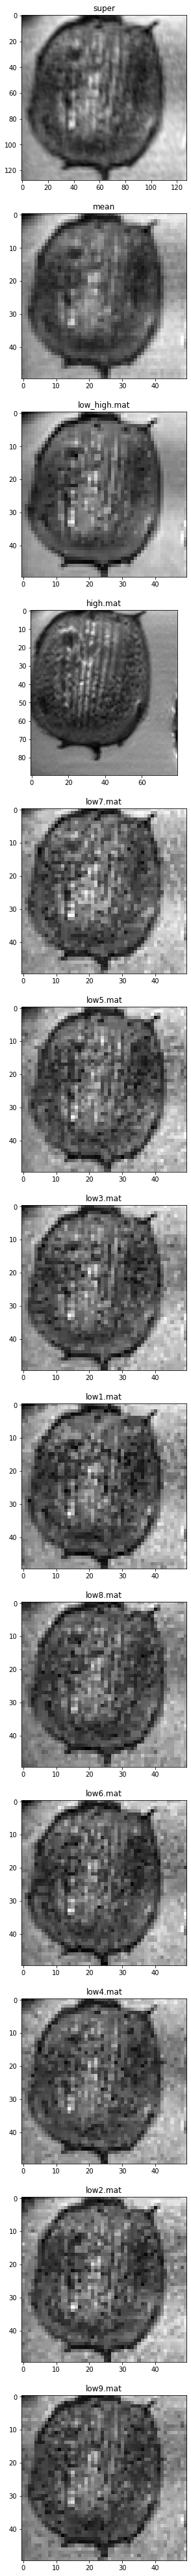

In [112]:
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(9):
    model_output = img_siren(model_input, i, 1/64.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= 9
#model_input  = get_mgrid(128, 2).cuda()
#model_output = img_siren(model_input).cpu().view((128,128)).detach().numpy()
fig, ax = plt.subplots(13,1,figsize=(6,72))
ax[0].imshow(mean_recon, cmap='gray')
ax[0].set_title('super')
ax[1].imshow(mean_img,cmap='gray')
ax[1].set_title('mean')
i=4
for inx in range(len(kiwi_scans)):
    _kiwi = kiwi_scans[inx]
    if 'low_high' in _kiwi.img_id:
        img = _kiwi.dwi[40:90,20:70]   
        ax[2].imshow(img,cmap='gray')
        ax[2].set_title(_kiwi.img_id)
    elif 'high.mat' in _kiwi.img_id:
        img = _kiwi.dwi[70:160,40:120]   
        ax[3].imshow(img,cmap='gray')
        ax[3].set_title(_kiwi.img_id)
    else:
        img = _kiwi.dwi[40:90,20:70]   
        ax[i].imshow(img,cmap='gray')
        ax[i].set_title(_kiwi.img_id)
        i+=1


In [1]:
model_output.max()

NameError: name 'model_output' is not defined

In [45]:
ground_truth.max()

tensor(7386.9629, device='cuda:0')

In [27]:
_case.pt_id

'17-1694-82'

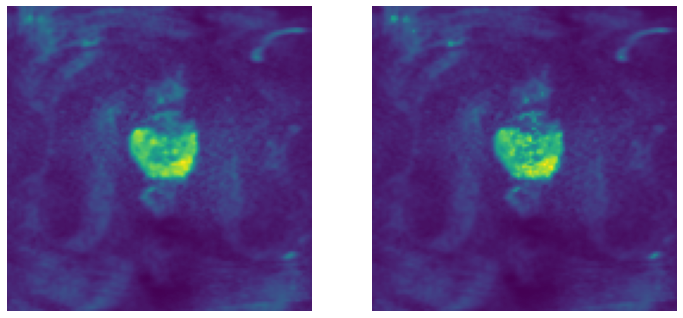

[1.341, 0.657, 7.069, 5.604, 1.261, 0.323]
[1.407, 0.831, 8.163, 6.0, 1.361, 0.32]


In [11]:
_case = cases[0]
seed = 0
img_siren = Siren(in_features=2, out_features=1, 
                      hidden_features=128,
                      hidden_layers=3, perturb=True)



PATH = os.path.join('models', _case.pt_id + '_' + str(seed) + '.pt')
img_siren.load_state_dict(torch.load(PATH))
img_siren.cuda()

_slice = _case.cancer_slice
b = _case.b[3]
b0 = _case.b0[:, :, _slice]
dwi = _case.b3[:, :, _slice, :]
img = np.mean(dwi,-1)
mean_recon = np.zeros((128,128))
model_input  = get_mgrid(128, 2).cuda()
for i in range(_case.b3.shape[3]):
    model_output = img_siren(model_input, i, 1.0/128.0)
    mean_recon += model_output.cpu().view(128,128).detach().numpy()
mean_recon /= _case.b3.shape[3]
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[1].imshow(mean_recon)
axes[0].imshow(img)
axes[0].axis('off')
axes[1].axis('off')
plt.show()
print([round(x,3) for x in calculate_CNR_SNR(_case, img)])
print([round(x,3) for x in calculate_CNR_SNR(_case, mean_recon)])

In [12]:
adc_in = calc_adc(img, _case.b0[:,:,_slice], _case.b[3])
adc_out = calc_adc(mean_recon, _case.b0[:,:,_slice], _case.b[3])

In [13]:
print([round(x,2) for x in calculate_CNR_SNR(_case, adc_in)])
print([round(x,2) for x in calculate_CNR_SNR(_case, adc_out)])

[0.64, 0.33, 1.01, 1.51, 0.67, 0.23]
[0.57, 0.41, 0.85, 1.44, 0.59, 0.23]


3.8435543965294787

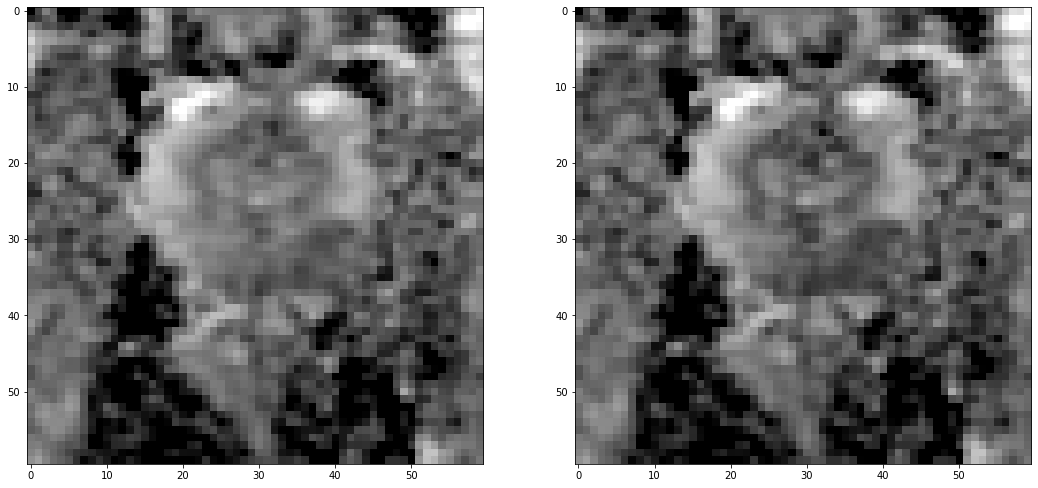

In [14]:
fig, ax = plt.subplots(1,2,figsize=(18,18))
ax[0].imshow(adc_in[35:95, 35:95], cmap='gray',vmin=0.0, vmax = 3)
ax[1].imshow(adc_out[35:95, 35:95], cmap='gray',vmin=0.0,vmax=3)
adc_out.max()

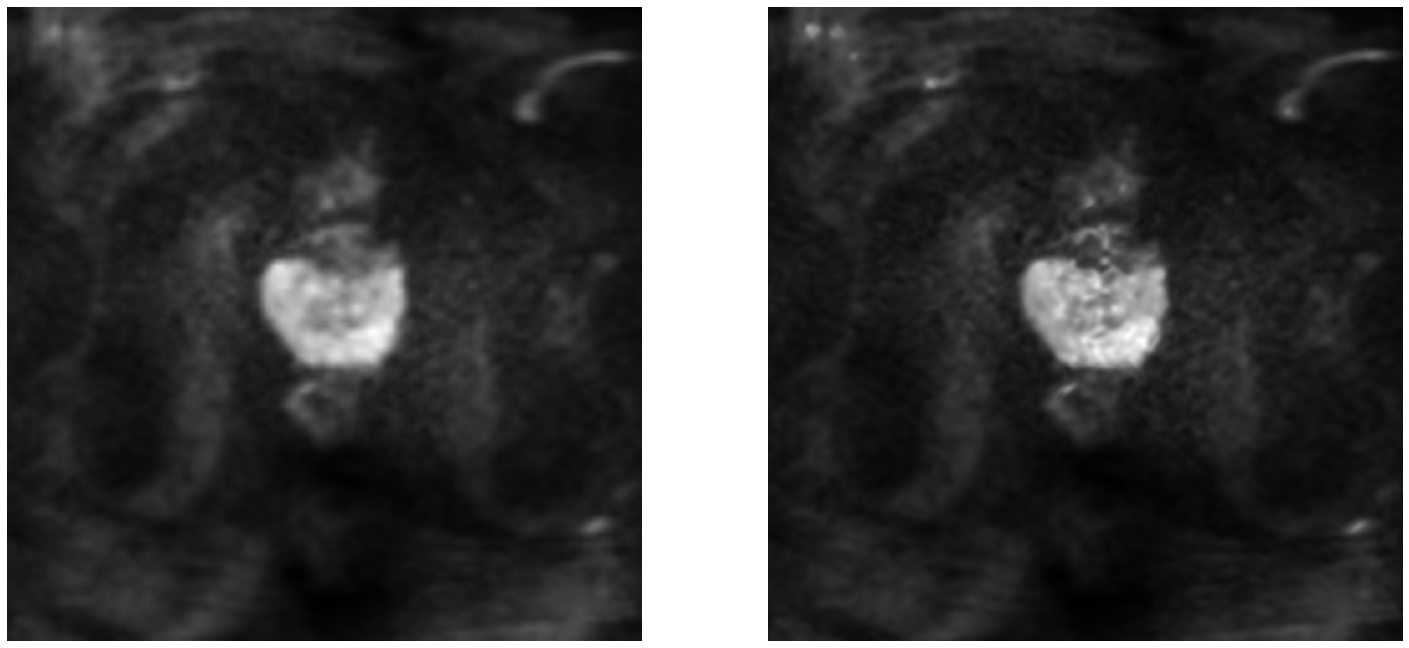

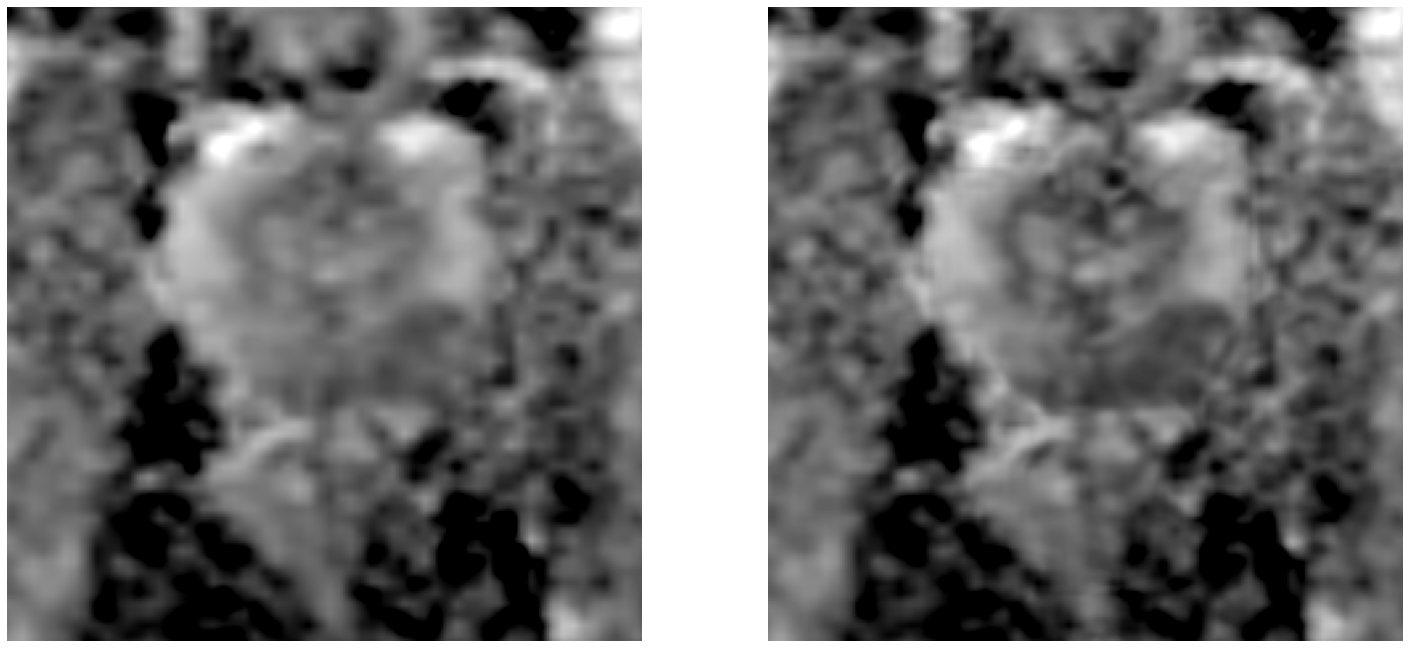

In [16]:
big_size = 512
big_mean = np.zeros((big_size,big_size))
model_input  = get_mgrid(big_size, 2).cuda()
for i in range(_case.b3.shape[3]):
    big_mean += img_siren(model_input, i, 1.0/128).cpu().view(big_size,big_size).detach().numpy()
big_mean /= _case.b3.shape[3]

fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[1].imshow(big_mean, cmap='gray')
axes[0].imshow(rescale(img,4), cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')
plt.show()


fig, axes = plt.subplots(1,2, figsize=(25,25))
axes[1].imshow(calc_adc(big_mean, rescale(b0,4), _case.b[3])[35*4:95*4,35*4:95*4], cmap='gray',vmin=0,vmax=3)
axes[0].imshow(rescale(calc_adc(img, b0, _case.b[3]),4)[35*4:95*4,35*4:95*4], cmap = 'gray',vmin=0,vmax=3)
axes[0].axis('off')
axes[1].axis('off')
plt.show()